In [2]:
import scipy as sc
import pandas as pd 
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import functools
import warnings
import tensorflow_probability as tfp
import tensorflow as tf

from src.vi import * 

tfd = tfp.distributions
tfb = tfp.bijectors

warnings.filterwarnings('ignore')

In [3]:
from src.df_processing import * 

x = pd.read_csv('../taxi+service+trajectory+prediction+challenge+ecml+pkdd+2015/interpolation'+'200'+'.csv')
dataset = extract_traj(x)
reshaped = np.array([i.reshape(-1) for i in dataset])
reshaped.shape
dataset = tf.cast(tf.transpose(tf.convert_to_tensor(reshaped)), tf.float32)

In [4]:
num_datapoints = 195
data_dim = 100
latent_dim = 11

In [38]:
def probabilistic_pca_tf(data_dim, latent_dim, num_datapoints, dataset):
  alpha = tfd.InverseGamma(concentration=1.0, scale=tf.ones(latent_dim), name="alpha_prior")
  alpha_sample = alpha.sample()

  sigma = tfd.LogNormal(loc=0.0,scale=1.0, name="sigma_prior")
  sigma = yield sigma

  w = yield tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                       scale=sigma * alpha_sample *tf.ones([data_dim, latent_dim]), name="w_prior")
  
  z = yield tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]), 
                                                     scale=tf.ones([latent_dim, num_datapoints]), name="z_prior")
  
  x = tfd.Normal(loc=tf.matmul(w,z), scale=sigma*tf.ones([data_dim, num_datapoints]))
  total_log_likelihood = tf.reduce_sum(x.log_prob(dataset))
  print(total_log_likelihood)
  x = yield x

  dict_var_lat = {'alpha': alpha, 'sigma':sigma,'w':w,'z':z, 'x':x}
  return dict_var_lat
concrete_ppca_model = functools.partial(probabilistic_pca_tf, 
                                        data_dim=data_dim, 
                                        latent_dim=latent_dim, 
                                        num_datapoints=num_datapoints, 
                                        dataset=dataset)

In [39]:
list_vars = probabilistic_pca_tf(data_dim=data_dim, latent_dim=latent_dim, num_datapoints=num_datapoints, dataset=dataset)

tf_model = tfd.JointDistributionCoroutineAutoBatched(concrete_ppca_model)
true_sigma, true_w, true_z, x_train = tf_model.sample()

Tensor("Sum:0", shape=(), dtype=float32)
tf.Tensor(-1555916.5, shape=(), dtype=float32)


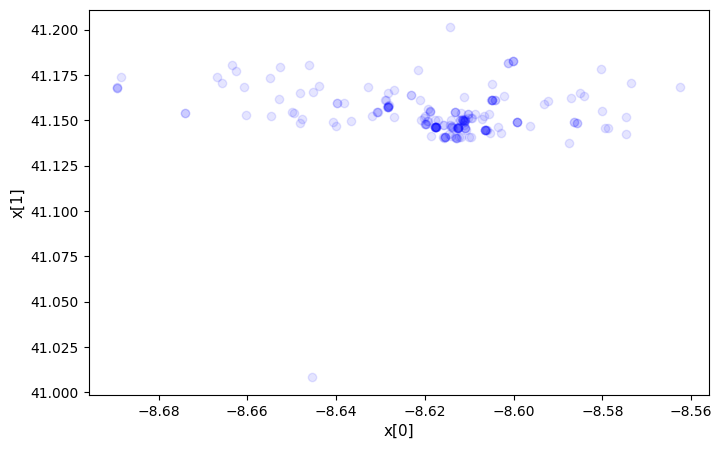

In [40]:
target_log_prob_fn_tf = lambda s, w, z: tf_model.log_prob((s,w, z, dataset)) # complete data log-likelihood

fig = plt.figure(figsize=(8, 5))
plt.scatter(dataset[0, :], dataset[1, :], color='blue', alpha=0.1)
plt.xlabel('x[0]', fontsize=11)
plt.ylabel('x[1]', fontsize=11)
plt.show()

In [6]:
def fct_obj(model):
    #objectif: Compute ∇_{theta}logp(x,θ)
    #### NAFIII 
    return 

def objective_fcts(model, mu, omega, tau, nb_samples): 
    nu = tf.Variable(tf.linalg.inv(tf.diag(tf.exp(omega)))@(tau-mu))
    # E_{N(0,I)}[∇_{theta}logp(x,θ)]
    fct_mu, esp_omega = MC_integration(model, nb_samples)
    # E_{N(0,I)}[∇ logp(x,θ)] + η diag(exp(ω)) +1
    return fct_mu, esp_omega + 1 # nu*tf.diag(tf.exp(omega)) + 1

def step_size(): 
    return 

def MC_integration(model, nb_samples): 
    esp_mu = 0
    esp_omega = 0
    for i in range(nb_samples): 
        esp_mu += fct_obj(model)
        esp_omega += fct_obj(model)
    return (1/nb_samples)*esp_mu, (1/nb_samples)*esp_omega

In [ ]:
def ADVI(x, tau, w, model, n_samples): 
    # Dataset x(1:N)
    N = len(x)
    # Model p(x,θ)
    i = 1 # Set iteration counter 

    # Parameter initialization 
    mu = tf.Variable(tf.zeros(size= N, requires_grad=True))
    omega = tf.Variable(tf.zeros(size= N, requires_grad=True)) # Mean-field   

    nu = tf.Variable(tf.linalg.inv(tf.diag(tf.exp(omega)))@(tau-mu))
    thr =  1e-4
    change_in_ELBO = 100
    # Define optimizer
    #optimizer = tf.optim.SGD([mu, omega], lr=0.01)

    while True: 
        # Draw M samples from normal stamdard multivariate gaussian
        # Approximate gradients (wrt mu and w) with MC integration 
        # Compute nu
        nu = tf.Variable(tfd.Normal(loc=tf.zeros([latent_dim, n_samples]), 
                                                     scale=tf.ones([latent_dim, n_samples])))

        fct_mu, fct_omega = objective_fcts(model, mu, omega, tau, n_samples)

        """ # Backpropagation to compute gradients
        optimizer.zero_grad()
        L.backward()

        # Get gradients with respect to mu and omega
        gradient_mu = mu.grad
        gradient_omega = omega.grad
        # Update parameters
        optimizer.step()
        """
        

        # Calculate step-size rho[i]
        rho = step_size(i, nu, rho)

        # Update mu and w 
        mu += np.diag(rho) @ fct_mu
        omega += np.diag(rho) @ fct_omega
        change_in_ELBO = np.abs()

        # increment iteration counter
        i +=1
        if abs(change_in_ELBO) < thr:
            break 

    return mu.item(), omega.item()

In [10]:
# initialize w, z as random variables
w = tf.Variable(tf.random.normal([data_dim, latent_dim]))
z = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))


qw_mean = tf.Variable(tf.random.normal([data_dim, latent_dim]))
qz_mean = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))

### this is similar to the TransformedDistribution used before, instead of distribution object, it returns a variable
qw_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([data_dim, latent_dim]),
                                        bijector=tfb.Softplus()) # softplus ensures the output to be positiv

print ('check qw_stddev: ', type(qw_stddv), qw_stddv)

qz_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([latent_dim, num_datapoints]),
                                        bijector=tfb.Softplus())

################

def factored_normal_variational_model():
  qw = yield tfd.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
  qz = yield tfd.Normal(loc=qz_mean, scale=qz_stddv, name="qz")

# like before we define a joint distribution
surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(factored_normal_variational_model) # joint distribution q(w, z)

In [12]:
from src.df_processing import * 

x = pd.read_csv('../taxi+service+trajectory+prediction+challenge+ecml+pkdd+2015/interpolation'+'200'+'.csv')
dataset = extract_traj(x)
reshaped = np.array([i.reshape(-1) for i in dataset])
reshaped.shape
dataset = tf.convert_to_tensor(reshaped)